# Experiments Theory of Mind in teacher-learner gridworld setup 
## Accuracy and uncertainty of the Bayesian ToM models

In this notebook we evaluate the ToM model of our teachers by computing the accuracy of the Maximu A Posteriori (MAP) estimators of the learner's goal and receptive field size from the beliefs of the teacher. We also compute the Shannon entropy to evaluate the uncertainty of the ToM model.

In [1]:
from __future__ import annotations
import warnings

import sys
sys.path.append('../')

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
from matplotlib import patches
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from PIL import Image

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv 
from learner import BayesianLearner
from bayesian_ToM.bayesian_teacher import AlignedBayesianTeacher, BayesianTeacher
from tools.utils import *
from tools.utils_viz import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33

num_colors = 4

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

num_rf = len(rf_values)
num_rf_demo = len(rf_values_demo)

### Statistics on the utility of the teachers - Rationality Principle based / Aligned

In [3]:
print(f'MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE ** 2}) \n')

print(f'MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO ** 2 // 2}) \n')

lambd = 0.01

print(f'Teacher: \n \
      Boltzmann temperatire lambda={lambd}')

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 11
       (max_steps=121) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 33
       (max_steps=544) 

Teacher: 
       Boltzmann temperatire lambda=0.01


In [5]:
lambd_values = [0.01, 0.5, 1., 3., 10.]
grid_size_values = [GRID_SIZE]

N = 200

save_filename = f'./outputs/eval_ToM/obs_{GRID_SIZE}.pickle'
folder = f'./outputs/eval_ToM'

In [20]:
DICT = {}

# Progress bar
# print(f'Progress lambda={lambd}:', end='\n')
pbar = progressbar.ProgressBar(maxval=len(grid_size_values) * num_colors * (len(rf_values)+1) * N).start()
nn = 0

for kk,GRID_SIZE in enumerate(grid_size_values):
    dict = {}
    for rf_idx,receptive_field in enumerate(rf_values):
        dict[receptive_field] = {}
        for goal_color in range(num_colors):
            dict[receptive_field][goal_color] = {}

            for lambd in lambd_values:
                dict[receptive_field][goal_color][lambd] = {}
                dict[receptive_field][goal_color][lambd]['goal'] = {}
                dict[receptive_field][goal_color][lambd]['rf'] = {}
                dict[receptive_field][goal_color][lambd]['goal']['accuracy'] = []
                dict[receptive_field][goal_color][lambd]['rf']['accuracy'] = []
                dict[receptive_field][goal_color][lambd]['length'] = []
                dict[receptive_field][goal_color][lambd]['length_key'] = []
                dict[receptive_field][goal_color][lambd]['goal']['beliefs'] = []
                dict[receptive_field][goal_color][lambd]['rf']['beliefs'] = []

            dict[receptive_field][goal_color]['aligned'] = {}
            dict[receptive_field][goal_color]['aligned']['goal'] = {}
            dict[receptive_field][goal_color]['aligned']['rf'] = {}
            dict[receptive_field][goal_color]['aligned']['goal']['accuracy'] = []
            dict[receptive_field][goal_color]['aligned']['rf']['accuracy'] = []
            dict[receptive_field][goal_color]['aligned']['length'] = []
            dict[receptive_field][goal_color]['aligned']['length_key'] = []
            dict[receptive_field][goal_color]['aligned']['goal']['beliefs'] = []
            dict[receptive_field][goal_color]['aligned']['rf']['beliefs'] = []

            for _ in range(N):
                learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
                teachers = [BayesianTeacher(env=learner.env, lambd=lambd, rf_values=rf_values_basic) for lambd in lambd_values]
                aligned_teacher = AlignedBayesianTeacher(env=learner.env, rf_values=rf_values_basic)

                ii = 0

                # Stat on Bayesian teacher (approximative policy)
                for tt, teacher in enumerate(teachers):
                    lambd = lambd_values[tt]

                    goal_belief = np.sum(teacher.beliefs.copy(), axis=0)
                    argmax_goals = np.argmax(goal_belief)

                    rf_belief = np.sum(teacher.beliefs.copy(), axis=0)
                    argmax_rfs = np.argmax(rf_belief)

                    dict[receptive_field][goal_color][lambd]['goal']['accuracy'].append(goal_color == argmax_goals)
                    dict[receptive_field][goal_color][lambd]['goal']['beliefs'].append(np.sum(teacher.beliefs.copy(), axis=1))
                    dict[receptive_field][goal_color][lambd]['rf']['accuracy'].append(rf_idx == argmax_rfs)
                    dict[receptive_field][goal_color][lambd]['rf']['beliefs'].append(np.sum(teacher.beliefs.copy(), axis=0))
                    dict[receptive_field][goal_color][lambd]['length'].append(ii)

                # Stat on Aligned teacher (exact policy)
                aligned_goal_belief = np.sum(aligned_teacher.beliefs.copy(), axis=0)
                argmax_goals = np.argmax(aligned_goal_belief)

                aligned_rf_belief = np.sum(aligned_teacher.beliefs.copy(), axis=0)
                argmax_rfs = np.argmax(aligned_rf_belief)
                
                dict[receptive_field][goal_color]['aligned']['goal']['accuracy'].append(goal_color == argmax_goals)
                dict[receptive_field][goal_color]['aligned']['goal']['beliefs'].append(np.sum(aligned_teacher.beliefs.copy(), axis=1))
                dict[receptive_field][goal_color]['aligned']['rf']['accuracy'].append(rf_idx == argmax_rfs)
                dict[receptive_field][goal_color]['aligned']['rf']['beliefs'].append(np.sum(aligned_teacher.beliefs.copy(), axis=0))
                dict[receptive_field][goal_color]['aligned']['length'].append(ii)
                
                # End the experiment when the learner has reached the goal
                ii_key = None
                ii_key_added = False
                while not learner.terminated and ii < learner.max_steps:
                    if (ii_key is None) and (learner.env.carrying is not None):
                        ii_key = ii
                    
                    # Interaction
                    agent_pos = learner.env.agent_pos
                    agent_dir = learner.env.agent_dir
                    for teacher in teachers:
                        teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                    aligned_teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)

                    traj = learner.play(size=1)
                    assert(not np.isnan(aligned_teacher.beliefs[0, 0]))

                    ii += 1

                    # Stat on Bayesian teacher (approximative policy)
                    for tt, teacher in enumerate(teachers):
                        teacher.observe(traj[0])
                        lambd = lambd_values[tt]

                        goal_belief = np.sum(teacher.beliefs.copy(), axis=1)
                        argmax_goals = np.argmax(goal_belief)

                        rf_belief = np.sum(teacher.beliefs.copy(), axis=0)
                        argmax_rfs = np.argmax(rf_belief)

                        dict[receptive_field][goal_color][lambd]['goal']['accuracy'].append(goal_color == argmax_goals)
                        dict[receptive_field][goal_color][lambd]['goal']['beliefs'].append(np.sum(teacher.beliefs.copy(), axis=1))
                        dict[receptive_field][goal_color][lambd]['rf']['accuracy'].append(rf_idx == argmax_rfs)
                        dict[receptive_field][goal_color][lambd]['rf']['beliefs'].append(np.sum(teacher.beliefs.copy(), axis=0))
                        dict[receptive_field][goal_color][lambd]['length'].append(ii)
                        if (ii_key is not None) and (not ii_key_added):
                            dict[receptive_field][goal_color][lambd]['length_key'].append(ii_key)

                    # Stat on Aligned teacher (exact policy)
                    aligned_teacher.observe(traj[0])
                    aligned_goal_belief = np.sum(aligned_teacher.beliefs.copy(), axis=1)
                    argmax_goals = np.argmax(aligned_goal_belief)

                    aligned_rf_belief = np.sum(aligned_teacher.beliefs.copy(), axis=0)
                    argmax_rfs = np.argmax(aligned_rf_belief)

                    dict[receptive_field][goal_color]['aligned']['goal']['accuracy'].append(goal_color == argmax_goals)
                    dict[receptive_field][goal_color]['aligned']['goal']['beliefs'].append(np.sum(aligned_teacher.beliefs.copy(), axis=1))
                    dict[receptive_field][goal_color]['aligned']['rf']['accuracy'].append(rf_idx == argmax_rfs)
                    dict[receptive_field][goal_color]['aligned']['rf']['beliefs'].append(np.sum(aligned_teacher.beliefs.copy(), axis=0))
                    dict[receptive_field][goal_color]['aligned']['length'].append(ii)
                    if (ii_key is not None) and (not ii_key_added):
                        dict[receptive_field][goal_color]['aligned']['length_key'].append(ii_key)
                        ii_key_added = True
                
                if ii_key is None:
                    for tt, teacher in enumerate(teachers):
                        lambd = lambd_values[tt]
                        dict[receptive_field][goal_color][lambd]['length_key'].append(ii)
                    dict[receptive_field][goal_color]['aligned']['length_key'].append(ii)
                # Progress bar
                nn += 1
                pbar.update(nn)

    DICT[GRID_SIZE] = dict
    
    # Save dict
    make_dirs(folder)
    with open(save_filename, 'wb') as f:
        pickle.dump(DICT, f)

## Preprocess the results

In [ ]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33

num_colors = 4

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

num_rf = len(rf_values)
num_rf_demo = len(rf_values_demo)

lambd_values = [0.01, 0.5, 1., 3., 10.]
grid_size_values = [GRID_SIZE]

N = 200

In [ ]:
load_filename = f'../outputs/eval_ToM/obs_{GRID_SIZE}.pickle'

In [21]:
with open(load_filename, 'rb') as f:
    DICT = pickle.load(f)

## Goal

In [8]:
true_N = N * 4 * 3

In [22]:
all_hist_gaol = {}
all_hist_gaol_entropy = {}

for lambd in lambd_values + ['aligned']:
    all_length = []
    all_acc = []
    all_beliefs = []
    all_length_key = []

    for rf_idx, receptive_field in enumerate(rf_values):
        for goal_color in range(num_colors):
            all_length += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['length']
            all_length_key += DICT[GRID_SIZE][receptive_field][goal_color]['aligned']['length_key']
            all_acc += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['goal']['accuracy']
            all_beliefs += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['goal']['beliefs']

    hist = np.zeros((101, true_N))
    hist_entropy = np.zeros((101, true_N))

    begin_episode = np.where(np.array(all_length) == 0)[0]

    for n in trange(true_N):
        start = begin_episode[n]

        if all_length_key[n] != -1:
            end = all_length_key[n] + start + 1

        elif n < (true_N-1):
            end =  begin_episode[n+1]
        else:
            end = len(all_length)

        acc = np.array(all_acc)[start:end]
        length = np.array(all_length)[start:end]
        beliefs = np.array(all_beliefs)[start:end]

        for i in range(0, 101, 2):
            idx_pour = int(length[-1] * i / 100)
            if i == 0:
                idx_pour += 1
            hist[i, n] = acc[idx_pour]
            hist_entropy[i, n] = Shannon_entropy(beliefs[idx_pour])

    all_hist_gaol[lambd] = hist
    all_hist_gaol_entropy[lambd] = hist_entropy

100%|██████████| 2400/2400 [00:39<00:00, 60.73it/s]


## RF

In [23]:
all_hist_rf = {}
all_hist_rf_entropy = {}

for lambd in lambd_values + ['aligned']:
    all_length = []
    all_acc = []
    all_beliefs = []

    for rf_idx, receptive_field in enumerate(rf_values):
        for goal_color in range(num_colors):
            all_length += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['length']
            all_acc += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['rf']['accuracy']
            all_beliefs += DICT[GRID_SIZE][receptive_field][goal_color][lambd]['rf']['beliefs']
    
    hist = np.zeros((101, true_N))
    hist_entropy = np.zeros((101, true_N))

    begin_episode = np.where(np.array(all_length) == 0)[0]

    for n in trange(true_N):
        start = begin_episode[n]
        if n < (true_N-1):
            end =  begin_episode[n+1]
        else:
            end = len(all_length)

        acc = np.array(all_acc)[start:end]
        length = np.array(all_length)[start:end]
        beliefs = np.array(all_beliefs)[start:end]

        for i in range(0, 101, 2):
            idx_pour = int(length[-1] * i / 100)
            if i == 0:
                idx_pour += 1
            hist[i, n] = acc[idx_pour]
            hist_entropy[i, n] = Shannon_entropy(beliefs[idx_pour])

    all_hist_rf[lambd] = hist
    all_hist_rf_entropy[lambd] = hist_entropy

100%|██████████| 2400/2400 [00:40<00:00, 58.56it/s]


In [24]:
dict = {}
dict['all_hist_goal'] = all_hist_gaol
dict['all_hist_goal_entropy'] = all_hist_gaol_entropy

dict['all_hist_rf'] = all_hist_rf
dict['all_hist_rf_entropy'] = all_hist_rf_entropy

save_filename_processed = f'./outputs/eval_ToM/obs_{GRID_SIZE}_processed.pickle'
with open(save_filename_processed, 'wb') as f:
    pickle.dump(dict, f)

## Display the results

In [8]:
# Parameters

GRID_SIZE = 11
GRID_SIZE_DEMO = 33

num_colors = 4

rf_values_basic = [3, 5]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

num_rf = len(rf_values)
num_rf_demo = len(rf_values_demo)

lambd_values = [0.01, 0.5, 1., 3., 10.]
grid_size_values = [GRID_SIZE]

N = 200

true_N = N * 3 * 4

In [9]:
save_filename_processed = f'../outputs/eval_ToM/obs_{GRID_SIZE}_processed.pickle'

with open(save_filename_processed, 'rb') as f:
    dict = pickle.load(f)

all_hist_goal = dict['all_hist_goal']
all_hist_goal_entropy = dict['all_hist_goal_entropy']

all_hist_rf = dict['all_hist_rf']
all_hist_rf_entropy = dict['all_hist_rf_entropy']

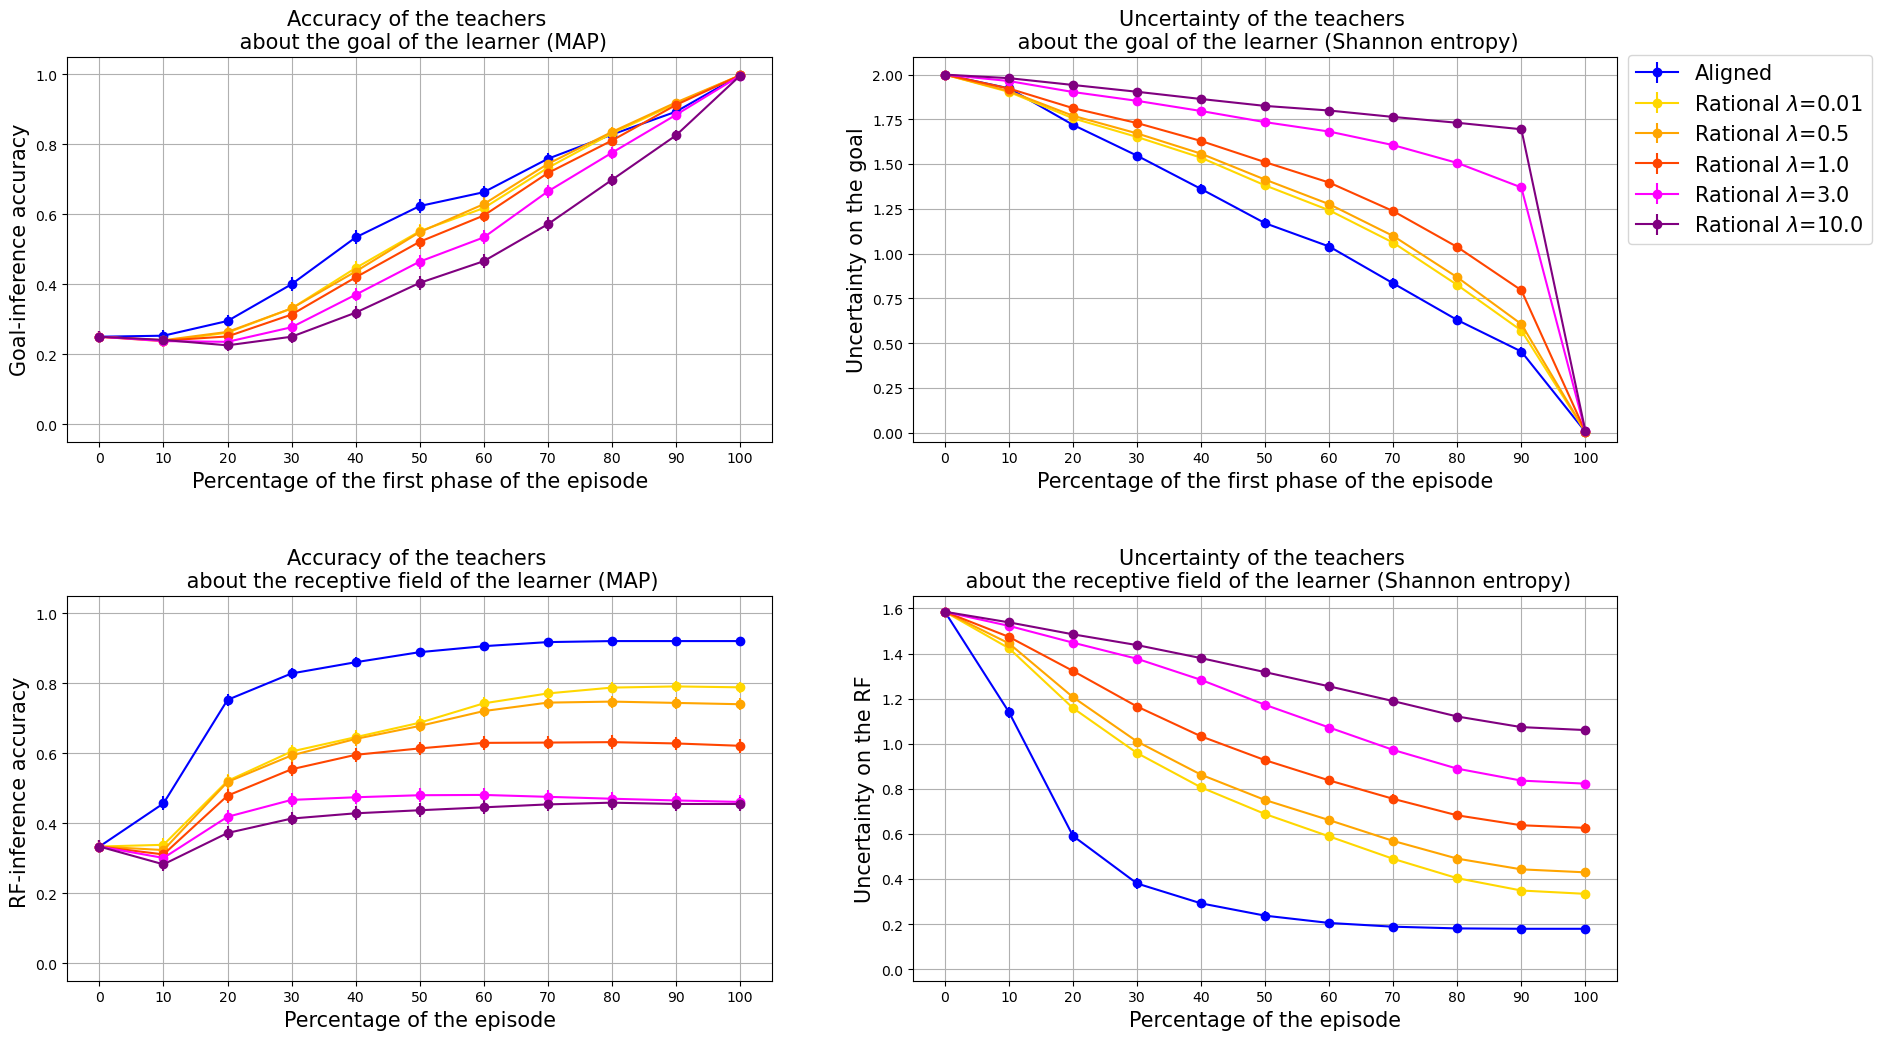

In [10]:
idx = np.arange(0, 101, 10)
colors = ['blue', 'gold', 'orange', 'orangered', 'magenta', 'purple']

fig = plt.figure(figsize=(20, 12))

for subplot_idx, (hist_data, title, ylabel) in enumerate([(all_hist_goal, 'Accuracy of the teachers \n about the goal of the learner (MAP)', 'Goal-inference accuracy'),
                                                          (all_hist_goal_entropy, 'Uncertainty of the teachers \n about the goal of the learner (Shannon entropy)', 'Uncertainty on the goal'),
                                                          (all_hist_rf, 'Accuracy of the teachers \n about the receptive field of the learner (MAP)', 'RF-inference accuracy '),
                                                          (all_hist_rf_entropy, 'Uncertainty of the teachers \n about the receptive field of the learner (Shannon entropy)', 'Uncertainty on the RF')]):
    ax = fig.add_subplot(2, 2, subplot_idx + 1)
    for kk, lambd in enumerate(['aligned'] + lambd_values):
        hist = hist_data[lambd]
        label = f'Rational $\lambda$={lambd}' if lambd != 'aligned' else 'Aligned'
        plt.errorbar(idx, np.mean(hist[idx], axis=1), yerr=1.96 * np.std(hist[idx], axis=1) / np.sqrt(true_N), marker='o', label=label, c=colors[kk])

    ax.set_title(title, fontsize=15)
    if subplot_idx in [0, 1]:
        ax.set_xlabel('Percentage of the first phase of the episode', fontsize=15)
    else:
        ax.set_xlabel('Percentage of the episode', fontsize=15)

    if subplot_idx % 2 == 0:
        ax.set_ylim(-0.05, 1.05)
    else:
        ax.set_ylim(-0.05)
        
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xticks(idx)
    ax.grid(True)

fig.subplots_adjust(hspace=0.4, wspace=0.2) 

# Create a shared legend for all subplots
lines, labels = ax.get_legend_handles_labels()
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.9, 0.89), fontsize=15)

plt.show()